# PROJECT 11: MACHINE LEARNING

### DESCRIPTION OF THE PROJECT:<BR>
 Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.<BR>

 I have access to behavior data about subscribers who have already switched to the new plans.<BR>
 
 For this classification task, I need to develop a model that will pick the right plan. Since I’ve already performed the data preprocessing step, I can move straight to creating the model.  

### GOAL OF THE PROJECT:<BR>

Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.  

***

### 1. IMPORT LIBRARIES.

In [49]:
# import libraries.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 

### 2. OPENING AND READING THE FILE.

In [50]:
# reading the csv file.
users = pd.read_csv('/Users/cesarchaparro/Desktop/TripleTen/Sprint_11/project/users_behavior.csv')
users

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


#### Columns are clean.<br>
#### 3214 Users.<br>
#### We can see that users with Ultra plan are assigned with 1, and the users with Smart plan are assigned with 0 on the column.

In [51]:
# info method to see types of data and missing values.
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


#### Non missing values.

***

### 3. EXPLORATORY DATA ANALYSIS.

In [52]:
# mean to see average values by plan group.
users.groupby(['is_ultra']).mean().T

is_ultra,0,1
calls,58.463437,73.392893
minutes,405.942952,511.224569
messages,33.384029,49.363452
mb_used,16208.466949,19468.823228


In [53]:
# calculate distribution by percentage by plan.
percentages = users.drop(columns = 'is_ultra').groupby(users['is_ultra']).sum() / users.drop(columns = 'is_ultra').sum() * 100
percentages.T

is_ultra,0,1
calls,64.319101,35.680899
minutes,64.246300,35.753700
messages,60.480672,39.519328
mb_used,65.325685,34.674315


#### Most of users belong to the Smart plan. We can see abobe on % for each plan.<br>
#### We can also see differences on each feature for each plan, they are nor balance on the behavior.

In [54]:
# describe method for each separate group plan for individual analysis.
for group in users['is_ultra'].unique():
    if group == 1:
        result = 'Ultra'
    else:
        result = 'Smart'
    print("Basic statistics for", result, "group")
    print("===============================================")
    display(users[users.is_ultra == group].describe())

Basic statistics for Smart group


,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


Basic statistics for Ultra group


,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


#### Correlation Matrix:<br>
#### It helps in identifying relationships between variables, detecting multicollinearity, reducing dimensionality, preprocessing data, gaining model insights, and detecting data issues. Understanding these correlations is foundational to building robust and interpretable machine learning model.

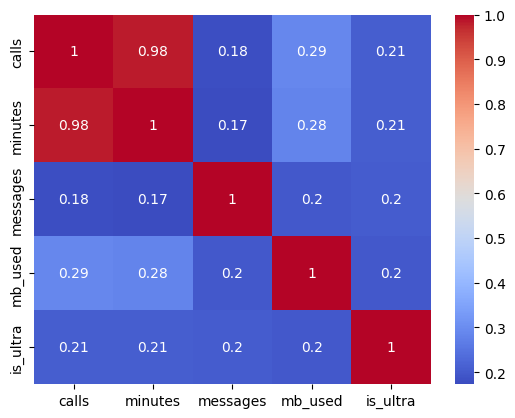

In [55]:
# calculate correlation matrix
correlation_matrix = users.corr()

# visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

#### The provided heatmap visualizes the correlation matrix among the variables: calls, minutes, messages, mb_used, and is_ultra. The color intensity represents the strength of the correlation, ranging from red (strong positive correlation) to blue (strong negative correlation).<br>

#### Calls and minutes exhibit a very strong positive correlation, as indicated by the intense red color. This suggests that users who make more calls tend to also have longer call durations.

#### Messages and minutes show a moderate positive correlation, implying that users who send more messages also tend to have longer call durations.<br>

#### There's a moderate positive correlation between mb_used and minutes, suggesting that users with higher data usage might also have longer calls.<br>

#### The relationship between calls, minutes, and messages with mb_used and is_ultra is relatively weak, as indicated by the lighter colors. This implies that these variables don't significantly influence data usage or ultra plan subscription.<br>

#### Since there are 2 features highly correlated, I will drop one of them on the below step.



In [56]:
clean_users = users.drop(['minutes'], axis=1)
clean_users.head()

,calls,messages,mb_used,is_ultra
0,40.0,83.0,19915.42,0
1,85.0,56.0,22696.96,0
2,77.0,86.0,21060.45,0
3,106.0,81.0,8437.39,1
4,66.0,1.0,14502.75,0


***

### 4. SPLIT THE SOURCE DATA INTO A TRAINING SET, A VALIDATION SET, AND A TEST SET.<br>

### 60% training dataset.<br>
### 20% validating dataset.<br>
### 20% test dataset.

In [57]:
train, valid = train_test_split(clean_users, test_size = 0.4, random_state = 42)
valid_set, test_set = train_test_split(valid, test_size = 0.5, random_state = 42)

In [58]:
train.shape

(1928, 4)

#### 60% for the training dataset is 1928.

In [59]:
valid.shape

(1286, 4)

In [60]:
display(valid_set.shape)
display(test_set.shape)

(643, 4)

(643, 4)

#### 20% for the validating dataset is 643.<br>

#### 20% for the test dataset is 643.

In [61]:
# divides a training dataset into features and a target variable.
features_train = train.drop('is_ultra', axis = 1)
target_train = train['is_ultra']
print(features_train.shape)
print(target_train.shape)

(1928, 3)
(1928,)


In [62]:
# divides a validation dataset into two parts: features and the target variable.
features_valid = valid_set.drop('is_ultra', axis = 1)
target_valid = valid_set['is_ultra']
print(features_valid.shape)
print(target_valid.shape)

(643, 3)
(643,)


In [63]:
# divides a test dataset into two parts: features and the target variable.
features_test = test_set.drop('is_ultra', axis = 1)
target_test = test_set['is_ultra']
print(features_test.shape)
print(target_test.shape)

(643, 3)
(643,)


***

### 5. DECISION TREE.

In [64]:
# creating the model.
dtc_model = DecisionTreeClassifier(random_state = 42)

# training on the training model.
dtc_model = dtc_model.fit(features_train,target_train)

In [65]:
#fitting predictions on the valid
valid_pred = dtc_model.predict(features_valid)

In [66]:
score = dtc_model.score(features_valid, target_valid)
score  

0.7573872472783826

#### <span style="color:yellow"> Accuracy 0.75738

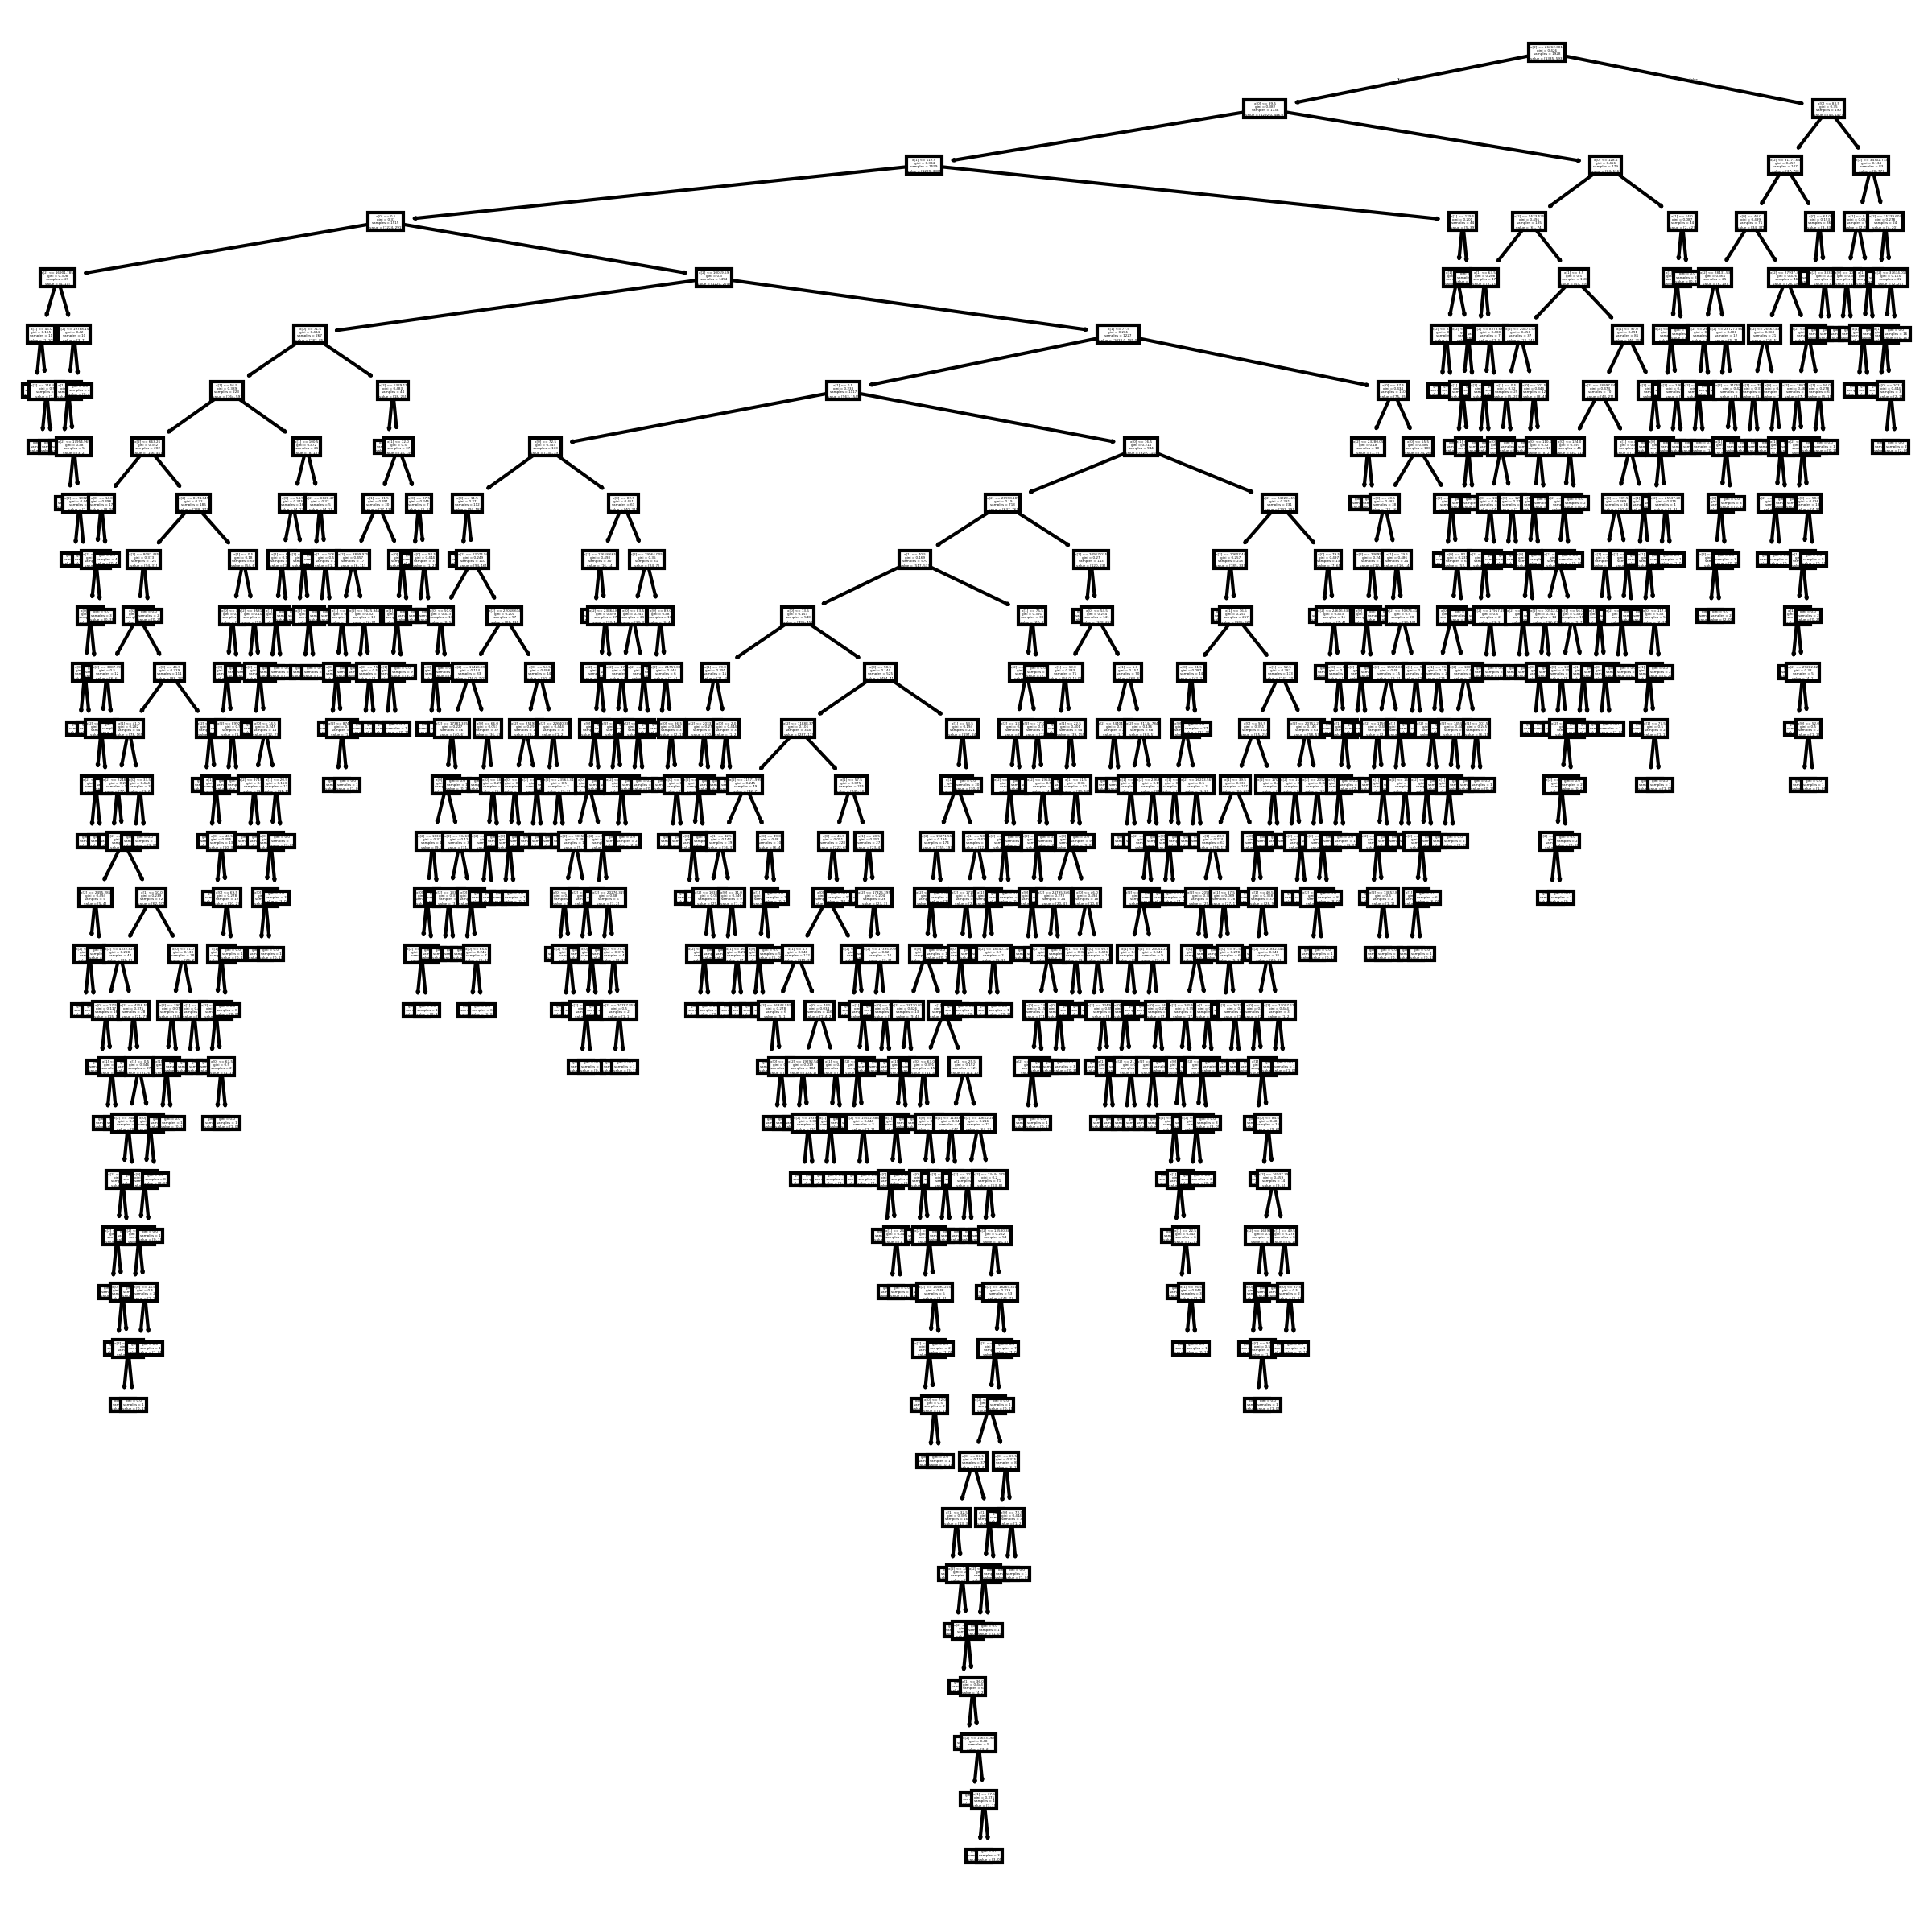

In [67]:
# plotting the decition tree.
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)

tree.plot_tree(dtc_model);

In [68]:
dtc_model.tree_.max_depth

32

In [69]:
# interating through a range to see the best accuracy.
final_depth = 0
final_score = 0
for depth in range(1, 10):
    dtc_model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    dtc_model.fit(features_train,target_train)
    valid_pred = dtc_model.predict(features_valid)
    accuracy = dtc_model.score(features_valid, target_valid)
    print("Final depth=", depth,"with accuracy:",accuracy)

Final depth= 1 with accuracy: 0.7558320373250389
Final depth= 2 with accuracy: 0.7916018662519441
Final depth= 3 with accuracy: 0.7962674961119751
Final depth= 4 with accuracy: 0.7822706065318819
Final depth= 5 with accuracy: 0.7916018662519441
Final depth= 6 with accuracy: 0.7838258164852255
Final depth= 7 with accuracy: 0.7884914463452566
Final depth= 8 with accuracy: 0.8133748055987559
Final depth= 9 with accuracy: 0.7978227060653188


#### <span style="color:yellow"> Best accuracy for Decition Tree with depth 8 = 0.81337

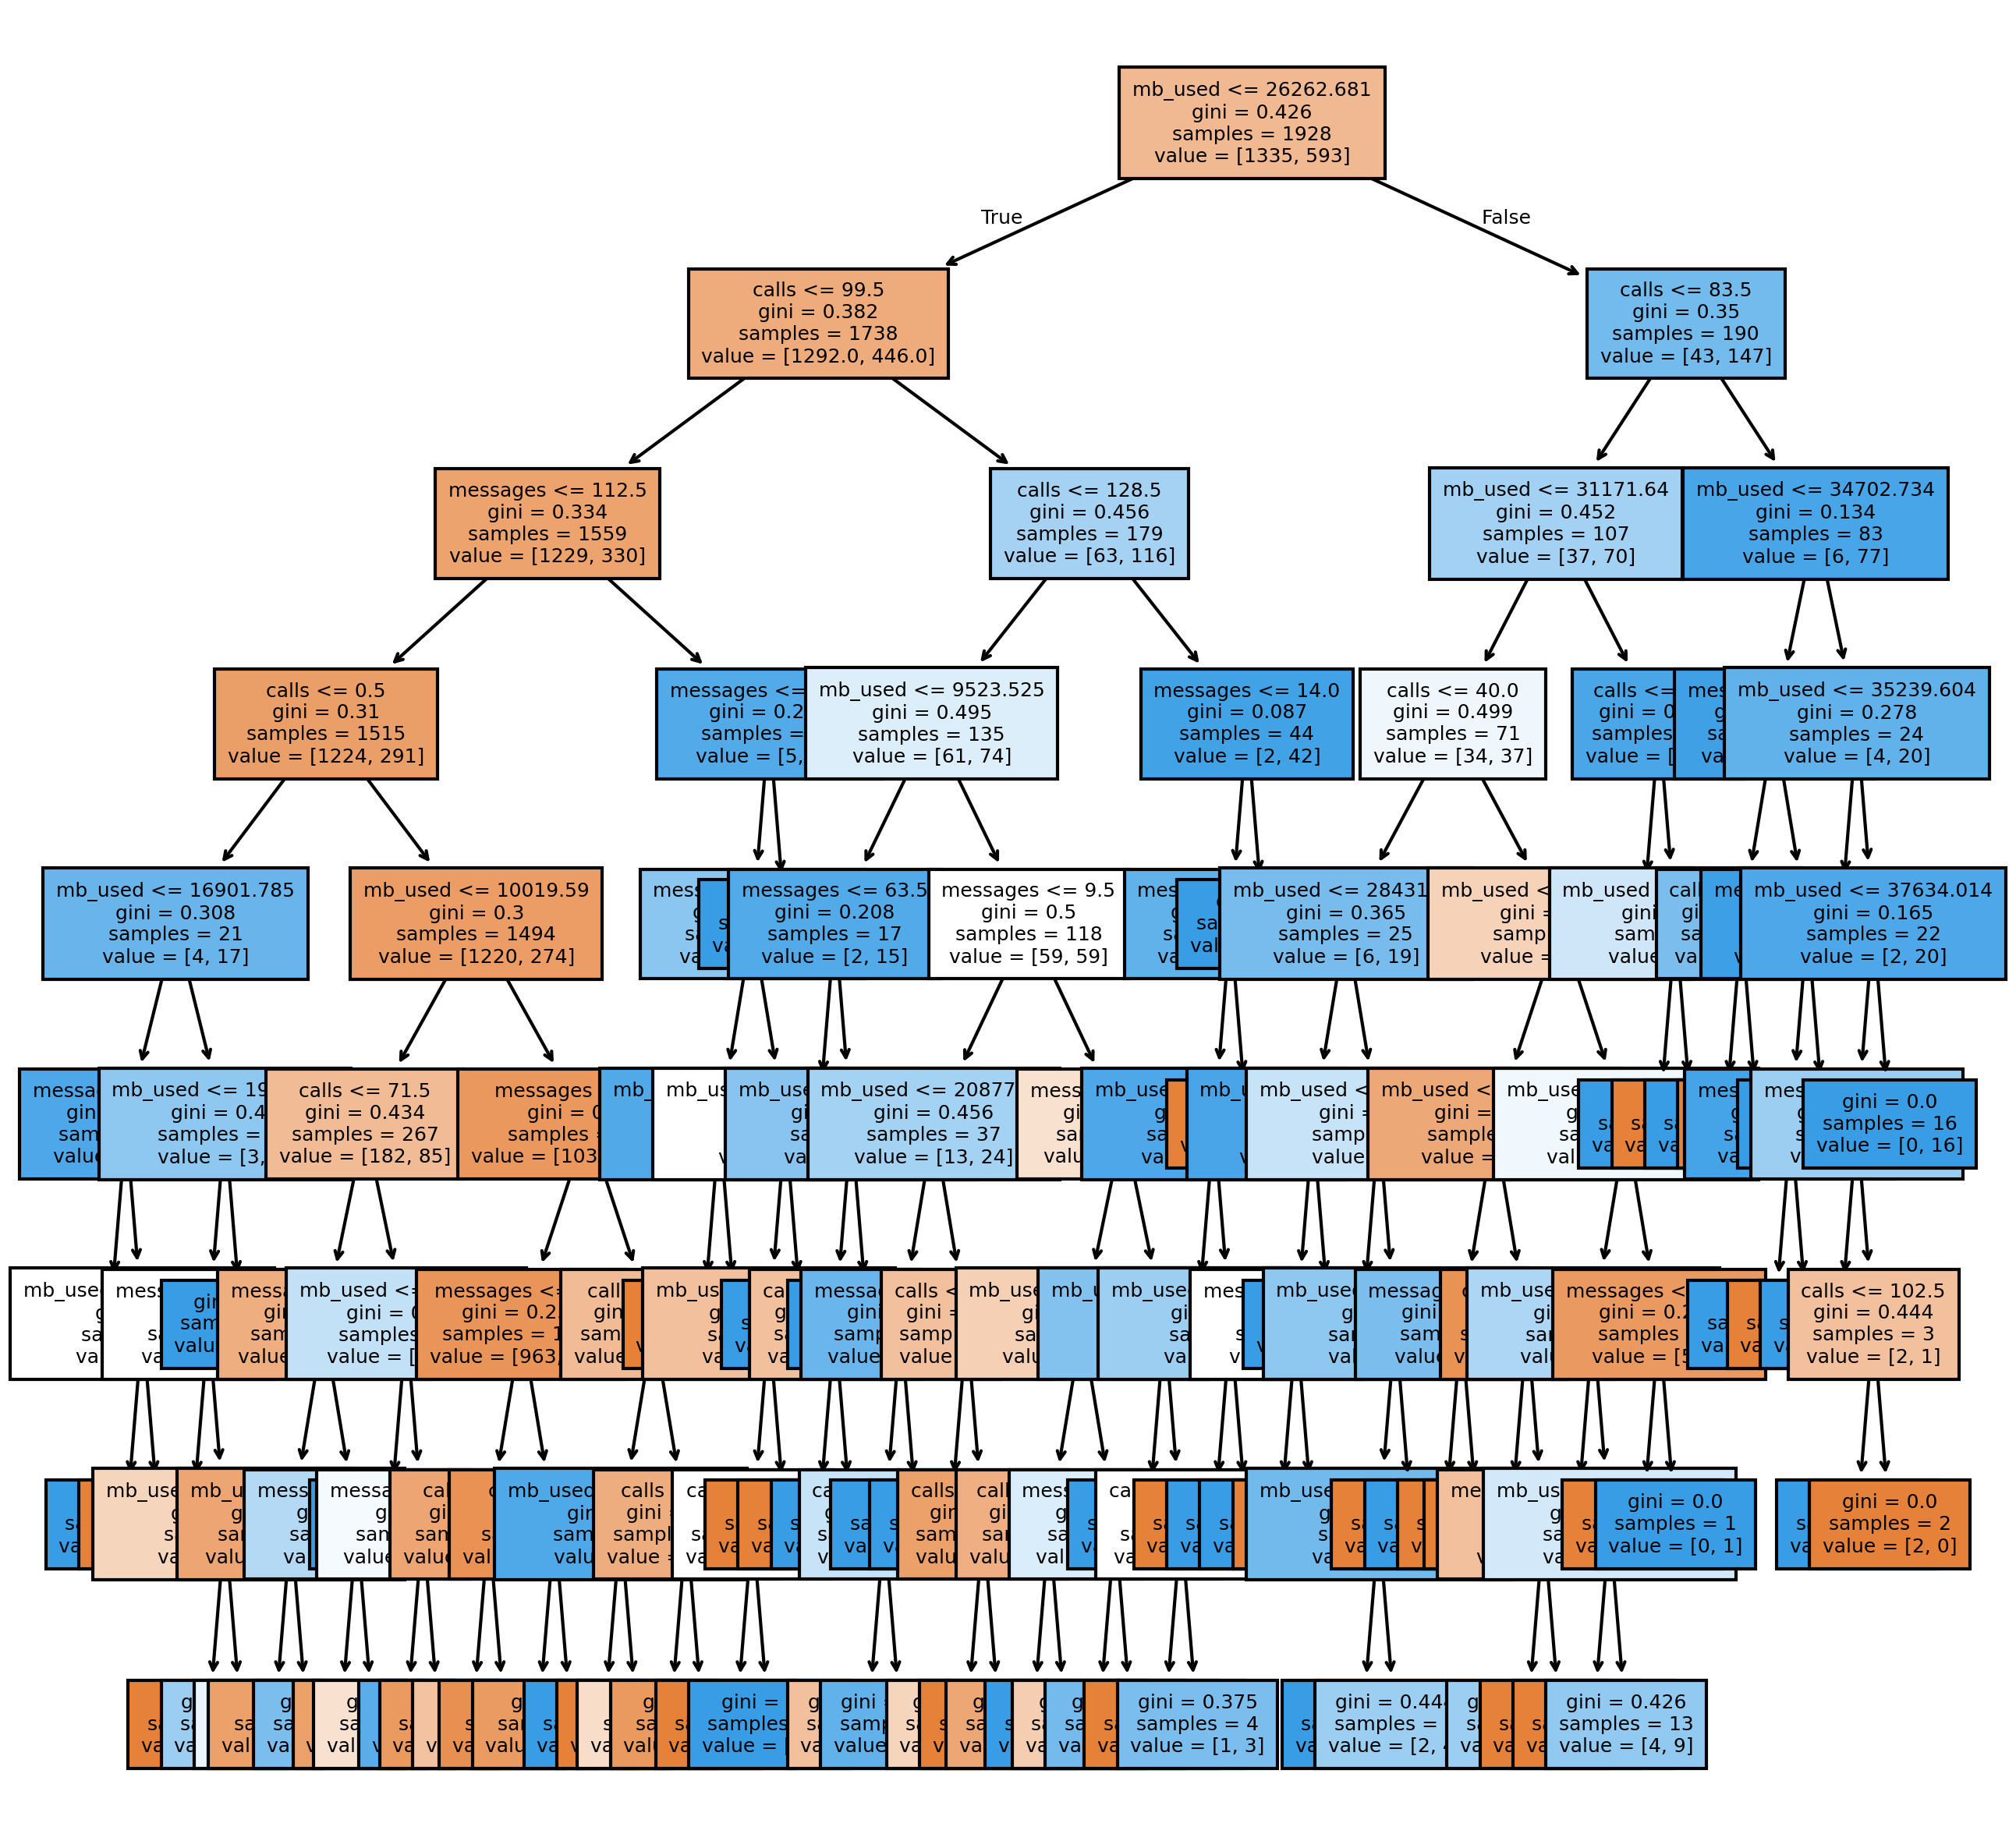

In [70]:
dtc_model = DecisionTreeClassifier(random_state = 42, max_depth = 8)
dtc_model.fit(features_train,target_train)
valid_pred = dtc_model.predict(features_valid)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)
tree.plot_tree(dtc_model,feature_names=features_train.columns,filled = True, fontsize = 6);

#### When having a decision tree model and want to evaluate its performance, the confusion matrix helps understand the number of correct and incorrect predictions made by the model.

In [71]:
cm = confusion_matrix(target_test, valid_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[365  83]
 [159  36]]


#### Analysis<br>
True Negatives (365): The model is good at correctly identifying negative cases.<br>

False Positives (83): There is a moderate number of negative cases being incorrectly classified as positive.<br>

False Negatives (159): The model is missing a significant number of positive cases, which could be problematic depending on the application.<br>

True Positives (36): The model is able to correctly identify some positive cases, but not very many.

#### Tuning the model with hyperparameters.

In [72]:
# creating the model.
dtc_model_tuned = DecisionTreeClassifier(random_state = 42, class_weight={0: 1, 1: 3.1}, max_depth = 6)
# training on the training model.
dtc_model_tuned = dtc_model_tuned.fit(features_train,target_train)

In [73]:
accuracy_tuned = dtc_model_tuned.score(features_valid, target_valid)
print("Accuracy:", accuracy_tuned)

Accuracy: 0.7791601866251944


#### <span style="color:yellow"> Accuracy: 0.77916

In [74]:
dtc_predictions_test = dtc_model_tuned.predict(features_test)
dtc_accuracy_test = accuracy_score(target_test, dtc_predictions_test)
print("Decision Tree testing score:", dtc_accuracy_test)                 


Decision Tree testing score: 0.7900466562986003


#### <span style="color:yellow"> Test accuracy: 0.74805

### Analysis:<br>

***

### 6. RANDOM FOREST.

In [75]:
# iterating through range of trees to see best accuracy.
final_est = 0
final_score = 0
for n in range(1, 100):
    rfc_model = RandomForestClassifier(random_state = 42, n_estimators = n)
    rfc_model.fit(features_train,target_train)
    score = rfc_model.score(features_valid, target_valid)
    if score > final_score:
        final_score = score
        best_est = n
    print(n,final_score)

1 0.7216174183514774
2 0.7682737169517885
3 0.7729393468118196
4 0.7884914463452566
5 0.7884914463452566
6 0.7931570762052877
7 0.7931570762052877
8 0.7931570762052877
9 0.7931570762052877
10 0.7931570762052877
11 0.7931570762052877
12 0.7931570762052877
13 0.7947122861586314
14 0.7947122861586314
15 0.7962674961119751
16 0.7962674961119751
17 0.8009331259720062
18 0.80248833592535
19 0.80248833592535
20 0.80248833592535
21 0.8055987558320373
22 0.8055987558320373
23 0.8055987558320373
24 0.8055987558320373
25 0.8055987558320373
26 0.8055987558320373
27 0.8055987558320373
28 0.8055987558320373
29 0.8055987558320373
30 0.8055987558320373
31 0.8055987558320373
32 0.8055987558320373
33 0.8055987558320373
34 0.8055987558320373
35 0.8055987558320373
36 0.807153965785381
37 0.8087091757387247
38 0.8102643856920684
39 0.8102643856920684
40 0.8102643856920684
41 0.8102643856920684
42 0.8102643856920684
43 0.8102643856920684
44 0.8102643856920684
45 0.8102643856920684
46 0.8102643856920684
47 0

#### <span style="color:yellow"> Best accuracy for Random Forest with number of estimators 54 = 0.81337

#### Tuning the model with hyperparameters.

In [76]:
param_grid = { 
	'n_estimators': [25, 50, 100, 150], 
	'max_features': ['sqrt', 'log2', None], 
	'max_depth': [3, 6, 9], 
	'max_leaf_nodes': [3, 6, 9], 
} 


In [77]:
grid_search = GridSearchCV(RandomForestClassifier(), 
						param_grid = param_grid) 
grid_search.fit(features_train, target_train) 
print(grid_search.best_estimator_) 


RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=25)


#### Update the parameters of the model by those which are obtained by using GridSearchCV.

In [78]:
model_grid = RandomForestClassifier(max_depth = 6, 
									max_features = None, 
									max_leaf_nodes = 9, 
									n_estimators = 50) 
model_grid.fit(features_train, target_train) 
target_pred_grid = rfc_model.predict(features_test) 
print(classification_report(target_pred_grid, target_test))  


              precision    recall  f1-score   support

           0       0.92      0.84      0.88       490
           1       0.59      0.76      0.67       153

    accuracy                           0.82       643
   macro avg       0.76      0.80      0.77       643
weighted avg       0.84      0.82      0.83       643



#### <span style="color:yellow"> Accuracy = 0.82

#### Use RandomizedSearchCV to obtain the best parameters for the model.

In [79]:
random_search = RandomizedSearchCV(RandomForestClassifier(), 
								param_grid) 
random_search.fit(features_train, target_train) 
print(random_search.best_estimator_) 


RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=6,
                       n_estimators=150)


#### Update the parameters of the model by those which are obtained by using RandomizedSearchCV.

In [80]:
model_random = RandomForestClassifier(max_depth = 6, 
									max_leaf_nodes = 9,
									max_features = 'log2',
									n_estimators = 150) 
model_random.fit(features_train, target_train) 
target_pred_rand = rfc_model.predict(features_test) 
print(classification_report(target_pred_rand, target_test)) 


              precision    recall  f1-score   support

           0       0.92      0.84      0.88       490
           1       0.59      0.76      0.67       153

    accuracy                           0.82       643
   macro avg       0.76      0.80      0.77       643
weighted avg       0.84      0.82      0.83       643



#### <span style="color:yellow"> Accuracy = 0.82

***

### 7. LOGISTICS REGRESSION.

In [81]:
lr_model = LogisticRegression(random_state = 42, solver = 'liblinear')
lr_model.fit(features_train,target_train)
score = lr_model.score(features_valid, target_valid)
print("Logistic regression training score:", score)

Logistic regression training score: 0.7169517884914464


#### <span style="color:yellow"> Accuracy for Logistic Regression Model = 0.71695

In [82]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300]
}

In [83]:
clf = GridSearchCV(lr_model, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)

In [84]:
xclf = GridSearchCV(lr_model, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf = xclf.fit(features_train, target_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [85]:
print("Best Parameters:", best_clf.best_params_)

Best Parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}


#### Update the parameters of the model by those which are obtained by using GridSearchCV.

In [88]:
best_params = best_clf.best_params_


In [89]:
updated_lr_model = LogisticRegression(
    C = best_params['C'], 
    max_iter = best_params['max_iter'], 
    solver = best_params['solver'],
    random_state = 42
)

In [90]:
updated_lr_model.fit(features_train, target_train)

LogisticRegression(C=0.1, random_state=42)

In [91]:
updated_score = updated_lr_model.score(features_valid, target_valid)
print("Updated Logistic Regression model score:", updated_score)

Updated Logistic Regression model score: 0.7340590979782271


#### <span style="color:yellow"> Accuracy for Logistic Regression Model = 0.7340

***

### 8. KNEIGHBORS CLASSIFIER.

In [95]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [96]:
knn.fit(features_train, target_train)

KNeighborsClassifier(n_neighbors=3)

In [97]:
predictions = knn.predict(features_test)

In [98]:
score = accuracy_score(target_test, predictions)

print(f"Kneighbors Classifier Test Accuracy: {score}")

Kneighbors Classifier Test Accuracy: 0.7340590979782271


#### <span style="color:yellow"> Accuracy for Kneighbors Classifier Model = 0.73405

In [100]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [101]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)

In [102]:
g_res = gs.fit(features_train, target_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


In [103]:
g_res.best_score_

0.7432651980187627

#### <span style="color:yellow"> Accuracy for Tuned Kneighbors Classifier Model = 0.74326

In [104]:
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}

In [105]:
knn = KNeighborsClassifier(n_neighbors = 13, weights = 'uniform', algorithm = 'brute', metric = 'manhattan')
knn.fit(features_train, target_train)

KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=13)

In [106]:
target_hat = knn.predict(features_train)
target_knn = knn.predict(features_test)

In [107]:
print('Training set accuracy: ', metrics.accuracy_score(target_train, target_hat))
print('Test set accuracy: ',metrics.accuracy_score(target_test, target_knn))

Training set accuracy:  0.7608921161825726
Test set accuracy:  0.7636080870917574


#### <span style="color:yellow"> Best accuracy for Tuned Kneighbors Classifier with number of neighbors 13 = 0.76089

### 9. FINAL TEST.

#### Test for Random Forest model.

In [ ]:
rfc_predictions_test = rfc_model.predict(features_test)                 
rfc_accuracy_test = accuracy_score(target_test, rfc_predictions_test)
print("Random Forest testing score:", rfc_accuracy_test)

TypeError: 'float' object is not callable

#### Accuracy for Random Forest Model with Test set = 0.81959

#### Conclusion: Accuracy with Validation set was 0.81337 compared to the Test set was 0.81959, which is about the same score for both sets, that means that the model is performing very well, not overfitted nor underfitted.

#### Test for Logistic Regression model.

In [ ]:
lr_predictions_test = lr_model.predict(features_test)                 
lr_accuracy_test = accuracy_score(target_test, lr_predictions_test)
print("Logistic Regression testing score:", lr_accuracy_test)

Logistic Regression testing score: 0.7091757387247278


#### Accuracy for Logistic Regression Model with Test set = 0.702954

#### Conclusion: Accuracy with Validation set was 0.71695 compared to the Test set was 0.70295, which is lower than validation set, that means that the model was overperforming, overfitted.

#### Test for Kneighbors Classifier model.

In [ ]:
knn_test = knn.predict(features_test)                 
knn_accuracy_test = accuracy_score(target_test, knn_test)
print("Kneighbors Classifier testing score:", knn_accuracy_test)

Kneighbors Classifier testing score: 0.7636080870917574


#### Accuracy for Kneighbors Classifier Model with Test set = 0.75738

#### Conclusion: Accuracy with Validation set was 0.76360 compared to the Test set was 0.75738, which is lower than validation set, that means that the model was overperforming, overfitted.

### Model with the highest possible accuracy: Random Forest model with 0.81959% accuracy.

***

### 9. SANITY CHECK THE MODEL.